# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,57 mins 53 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_navdeep_wno3ur
H2O cluster total nodes:,1
H2O cluster free memory:,28.29 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'simu_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'simu_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (80000, 20)
Test shape: (20000, 19)


In [5]:
train.head()

C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise,fold
51965,1,0,0.839247,0.81573,0.233273,0.0712949,0.402164,1,1,3,-2.72091,0,1,0,1,-0.0685853,0.19742,0.128834,1
17435,1,1,0.525419,0.820907,0.512061,0.959843,0.623719,1,1,3,-2.72091,0,1,1,0,1.9267,0.897373,2.82408,2
48424,1,1,0.360269,0.75643,0.576162,0.532702,0.0432589,1,1,3,-2.72091,0,1,0,1,0.0715976,0.426443,0.498041,4
33915,1,0,0.229449,0.66919,0.843938,0.0922275,0.0338441,1,1,3,-2.72091,0,1,0,1,-0.951668,2.3566,1.40493,1
99940,0,0,0.674454,0.501915,0.423838,0.158557,0.562246,1,0,2,-2.72091,0,1,0,1,-0.370235,-0.0833795,-0.453614,2
13760,1,0,0.594695,0.485944,0.453524,0.377025,0.142704,1,1,3,-2.72091,0,1,0,1,-0.0891082,2.0873,1.99819,4
87850,0,0,0.554962,0.142204,0.640426,0.98044,0.445186,0,1,2,-2.72091,1,0,1,0,-0.545174,-0.499752,-1.04493,1
80162,0,0,0.21333,0.633964,0.603668,0.36097,0.247929,1,1,0,-2.72091,0,1,0,1,-0.983626,-0.710717,-1.69434,5
58687,0,0,0.368177,0.770775,0.198582,0.114277,0.0220358,1,1,3,-2.72091,0,1,0,1,-0.400844,-0.237349,-0.638193,5
44248,1,1,0.504913,0.78061,0.278483,0.407989,0.974955,1,1,2,-2.72091,0,1,0,1,0.55672,0.0060862,0.562806,3


In [6]:
train.summary()

,C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise,fold
type,int,int,int,real,real,real,real,real,int,int,int,real,int,int,int,int,real,real,real,int
mins,0.0,0.0,0.0,5.993720636792679e-06,5.8484963424982016e-06,1.0780942417172514e-05,1.2877269565669754e-06,1.1794417957365304e-05,0.0,0.0,0.0,-2.720908013105422,0.0,0.0,0.0,0.0,-3.08207822955209,-6.977000592821803,-7.12822858651175,1.0
mean,49959.91805,0.49935,0.5009,0.49977277129175884,0.5005156605400479,0.4997349160374042,0.49970378351051314,0.5003267108451945,0.5013875,0.8005,1.8754875,-2.720908013105422,0.14920000000000003,0.8508,0.493275,0.506725,0.0007982856251728531,-0.0006313009765887836,0.0001669846485840658,3.0018749999999996
maxs,99999.0,1.0,1.0,0.9999779765400002,0.9999890264956286,0.9999945142954458,0.9999815918221177,0.9999884430981296,1.0,1.0,4.0,-2.720908013105422,1.0,1.0,1.0,1.0,3.2888372264073396,6.470597632146622,5.904559925891165,5.0
sigma,28895.068624157895,0.500002702526478,0.5000023150235785,0.28829962574229046,0.2886715877500042,0.2882859755442119,0.2888185891874711,0.28884782872641634,0.5000011998573086,0.39962700893686903,1.188339930003665,3.418817590948131e-16,0.35628773029931093,0.35628773029931093,0.49995789707607935,0.49995789707607935,0.9119039514730629,0.9080878617558318,1.2845097123335294,1.4162879501603733
zeros,1,40052,39928,0,0,0,0,0,39889,15960,15969,0,68064,11936,40538,39462,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,51965.0,1.0,0.0,0.8392467973769617,0.8157304958676279,0.2332731763434404,0.07129490031080189,0.4021640971574773,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,-0.06858534100749303,0.19741968939352392,0.1288343483860309,1.0
1,17435.0,1.0,1.0,0.5254191073537032,0.820907136047182,0.512060973354806,0.95984262896293,0.6237194690232792,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,1.0,0.0,1.926704951999059,0.8973734832579258,2.8240784352569843,2.0
2,48424.0,1.0,1.0,0.3602693659010231,0.7564304080663468,0.5761618454587174,0.5327017334947878,0.043258948658088416,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,0.07159755219096109,0.4264432225168168,0.4980407747077779,4.0


In [7]:
test.head()

C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise
81101,0,0,0.849904,0.281757,0.885856,0.255401,0.356855,0,1,2,-2.72091,0,1,1,0,-0.691063,0.0320475,-0.659016
23267,0,0,0.0888431,0.833081,0.627163,0.0497448,0.50842,1,1,3,-2.72091,0,1,0,1,-1.43746,-1.79025,-3.22771
55847,1,0,0.126262,0.451901,0.732873,0.5199,0.48319,1,0,2,-2.72091,0,1,1,0,-0.924411,2.92769,2.00328
36104,1,0,0.139916,0.958078,0.0312187,0.142685,0.179793,1,0,3,-2.72091,0,1,0,1,-0.109132,0.141285,0.032153
13217,0,0,0.0162819,0.975709,0.0777005,0.0148265,0.115625,1,1,3,-2.72091,0,1,0,1,-1.61251,-0.00312947,-1.61564
62817,0,0,0.0199051,0.908849,0.848083,0.117873,0.564219,1,1,3,-2.72091,0,1,0,1,-1.17269,-0.344136,-1.51683
69779,1,1,0.342897,0.514568,0.281129,0.656239,0.909317,1,1,0,-2.72091,0,1,0,1,0.645227,0.599765,1.24499
67094,0,0,0.862784,0.255917,0.806889,0.32279,0.0876008,0,1,2,-2.72091,0,1,0,1,-1.13228,0.305278,-0.827003
53829,0,0,0.523056,0.379357,0.207451,0.618397,0.187829,0,0,2,-2.72091,0,1,1,0,-0.286394,-2.48516,-2.77156
20294,1,0,0.155356,0.703031,0.206925,0.585896,0.06441,1,1,3,-2.72091,0,1,0,1,-0.318272,1.16812,0.849848


In [8]:
test.summary()

,C1,outcome,outcome_no_noise,fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,intercept,prot_class1,ctrl_class1,prot_class2,ctrl_class2,latent_no_noise,logistic_noise,latent_with_noise
type,int,int,int,real,real,real,real,real,int,int,int,real,int,int,int,int,real,real,real
mins,2.0,0.0,0.0,5.354501783522957e-06,4.465679264262415e-06,1.120115784735912e-05,1.2345216481953824e-05,5.9251237695870275e-08,0.0,0.0,0.0,-2.720908013105422,0.0,0.0,0.0,0.0,-2.9708160865975466,-6.102900930067954,-8.18129580932468
mean,50157.8278,0.49935,0.49865,0.501443000565748,0.4976173346369308,0.5017576569954018,0.5017269859976043,0.4978021079745367,0.49735,0.8008,1.86995,-2.7209080131054217,0.15285,0.84715,0.4958,0.5042,-0.003193142500652191,0.0025252039063551803,-0.0006679385942970014
maxs,99977.0,1.0,1.0,0.9999935013680497,0.9999935603322316,0.9999683397720096,0.9999188775098924,0.9999883388723309,1.0,1.0,4.0,-2.720908013105422,1.0,1.0,1.0,1.0,3.1480336616634506,5.15068621320296,6.735894876511168
sigma,28757.92874371046,0.5000120779580282,0.5000106779198837,0.2898957467069073,0.288680541456105,0.2903051113246434,0.289784691650011,0.2887294511182761,0.500005477743883,0.39940873346337624,1.1828385151184597,3.5520670640187013e-16,0.35985184752562877,0.35985184752562877,0.4999948597165647,0.4999948597165647,0.924023667273663,0.9078968103490572,1.29195133858809
zeros,0,10013,10027,0,0,0,0,0,10053,3984,4001,0,16943,3057,10084,9916,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,81101.0,0.0,0.0,0.8499041678104391,0.28175709898797396,0.8858559099230232,0.2554011590887179,0.35685453705632375,0.0,1.0,2.0,-2.720908013105422,0.0,1.0,1.0,0.0,-0.6910631454449327,0.03204747166047098,-0.6590156737844618
1,23267.0,0.0,0.0,0.0888431184941566,0.8330812813075777,0.6271631716538477,0.049744820036620944,0.508419703971701,1.0,1.0,3.0,-2.720908013105422,0.0,1.0,0.0,1.0,-1.4374551476933446,-1.790254240468232,-3.2277093881615766
2,55847.0,1.0,0.0,0.12626159795934638,0.4519005042300335,0.7328727603071761,0.5199002402193534,0.48319034275008466,1.0,0.0,2.0,-2.720908013105422,0.0,1.0,1.0,0.0,-0.9244111076188346,2.9276933206503815,2.003282213031546


In [9]:
# Inputs and output
X = ["fried" + str(x) for x in range(1, 6)] + ["binary1", "binary2", "cat1"]
fold_column = 'fold'
Y = "outcome"

In [10]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [11]:
# Distribution of outcome in train
train[Y].table()

outcome,Count
0,40052
1,39948


In [12]:
# Distribution of outcome in test
test[Y].table()

outcome,Count
0,10013
1,9987


In [13]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [20]:
# Make monotonicity constraints dictionary, which is based on data generation script:
# f1: +
# f2: +
# f3: n/a
# f4: +
# f5: +
# b1: +
# b2: -
# c1: n/a
constraint = 1
mono_constraints = {feature:constraint for feature in X}
del mono_constraints['fried3']
del mono_constraints['cat1']
mono_constraints['binary2'] = -1
mono_constraints

{'fried1': 1,
 'fried2': 1,
 'fried4': 1,
 'fried5': 1,
 'binary1': 1,
 'binary2': -1}

In [21]:
# Default GBM with monotonic constraints
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575671949109_20410


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,16512.0,5.0,5.0,5.0,14.0,29.0,21.62




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1710612888084599
RMSE: 0.4135955618819669
LogLoss: 0.5175542571148526
Mean Per-Class Error: 0.24796481656053992
AUC: 0.8357850934143078
pr_auc: 0.8345141989803755
Gini: 0.6715701868286157

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43088807582498645: 


,,0,1,Error,Rate
0,0,25519.0,14533.0,0.3629,(14533.0/40052.0)
1,1,6107.0,33841.0,0.1529,(6107.0/39948.0)
2,Total,31626.0,48374.0,0.258,(20640.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.430888,0.766310,235.0
1,max f2,0.279813,0.858081,304.0
2,max f0point5,0.577054,0.764099,165.0
3,max accuracy,0.513705,0.752050,195.0
4,max precision,0.977432,1.000000,0.0
5,max recall,0.043862,1.000000,397.0
6,max specificity,0.977432,1.000000,0.0
7,max absolute_mcc,0.519362,0.504315,192.0
8,max min_per_class_accuracy,0.505206,0.750749,199.0
9,max mean_per_class_accuracy,0.513705,0.752035,195.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.22 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.924468,1.990087,1.990087,0.993750,0.943636,0.993750,0.943636,0.019901,0.019901,99.008711,99.008711
1,,2,0.02,0.901796,1.962551,1.976319,0.980000,0.912654,0.986875,0.928145,0.019626,0.039526,96.255132,97.631921
2,,3,0.03,0.884591,1.927506,1.960048,0.962500,0.892960,0.978750,0.916417,0.019275,0.058801,92.750576,96.004806
3,,4,0.04,0.870413,1.909983,1.947532,0.953750,0.877229,0.972500,0.906620,0.019100,0.077901,90.998298,94.753179
4,,5,0.05,0.856845,1.935016,1.945029,0.966250,0.863470,0.971250,0.897990,0.019350,0.097251,93.501552,94.502854
5,,6,0.10,0.799922,1.853910,1.899469,0.925750,0.827123,0.948500,0.862556,0.092696,0.189947,85.391008,89.946931
6,,7,0.15,0.752669,1.768799,1.855913,0.883250,0.775654,0.926750,0.833589,0.088440,0.278387,76.879944,85.591269
7,,8,0.20,0.712519,1.677681,1.811355,0.837750,0.732504,0.904500,0.808318,0.083884,0.362271,67.768099,81.135476
8,,9,0.30,0.639662,1.502704,1.708471,0.750375,0.675245,0.853125,0.763960,0.150270,0.512541,50.270351,70.847101
9,,10,0.40,0.572939,1.296686,1.605525,0.647500,0.606558,0.801719,0.724610,0.129669,0.642210,29.668569,60.552468




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.17290512023468296
RMSE: 0.4158186145841513
LogLoss: 0.5216247886336745
Mean Per-Class Error: 0.2511159593859713
AUC: 0.8304691200553128
pr_auc: 0.8282365279354957
Gini: 0.6609382401106256

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4205242614609366: 


,,0,1,Error,Rate
0,0,24602.0,15450.0,0.3857,(15450.0/40052.0)
1,1,5754.0,34194.0,0.144,(5754.0/39948.0)
2,Total,30356.0,49644.0,0.2651,(21204.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.420524,0.763327,238.0
1,max f2,0.264031,0.855888,312.0
2,max f0point5,0.578348,0.760340,160.0
3,max accuracy,0.513801,0.748900,192.0
4,max precision,0.974556,1.000000,0.0
5,max recall,0.038946,1.000000,397.0
6,max specificity,0.974556,1.000000,0.0
7,max absolute_mcc,0.513801,0.497926,192.0
8,max min_per_class_accuracy,0.505609,0.748298,196.0
9,max mean_per_class_accuracy,0.513801,0.748884,192.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.17 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.925190,1.982577,1.982577,0.990000,0.944184,0.990000,0.944184,0.019826,0.019826,98.257735,98.257735
1,,2,0.02,0.903007,1.955042,1.968809,0.976250,0.913535,0.983125,0.928859,0.019550,0.039376,95.504155,96.880945
2,,3,0.03,0.886051,1.917493,1.951704,0.957500,0.894231,0.974583,0.917317,0.019175,0.058551,91.749274,95.170388
3,,4,0.04,0.870192,1.925003,1.945029,0.961250,0.878110,0.971250,0.907515,0.019250,0.077801,92.500250,94.502854
4,,5,0.05,0.856950,1.897467,1.935516,0.947500,0.863502,0.966500,0.898712,0.018975,0.096776,89.746671,93.551617
5,,6,0.10,0.801263,1.843897,1.889707,0.920750,0.828433,0.943625,0.863573,0.092195,0.188971,84.389707,88.970662
6,,7,0.15,0.754722,1.752779,1.844064,0.875250,0.777049,0.920833,0.834732,0.087639,0.276610,75.277861,84.406395
7,,8,0.20,0.713273,1.652148,1.796085,0.825000,0.733520,0.896875,0.809429,0.082607,0.359217,65.214779,79.608491
8,,9,0.30,0.638995,1.492941,1.695037,0.745500,0.675345,0.846417,0.764734,0.149294,0.508511,49.294082,69.503688
9,,10,0.40,0.571676,1.303945,1.597264,0.651125,0.605074,0.797594,0.724819,0.130395,0.638906,30.394513,59.726394




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.73370296,0.005058888,0.7410336,0.7273689,0.7357053,0.7321574,0.7322496
1,auc,0.8304981,0.004012103,0.83293355,0.8275021,0.8363991,0.82738155,0.8282742
2,err,0.26629704,0.005058888,0.2589664,0.2726311,0.2642947,0.26784256,0.26775038
3,err_count,4260.8,87.494,4159.0,4382.0,4197.0,4267.0,4299.0
4,f0point5,0.71484613,0.007992947,0.7271718,0.70579344,0.7171616,0.71264297,0.71146077
5,f1,0.76380444,0.0054346886,0.76946956,0.7592572,0.769813,0.76163346,0.75884897
6,f2,0.8200283,0.0067388234,0.8169919,0.8214846,0.83080786,0.8178568,0.8130003
7,lift_top_group,1.980337,0.026405234,1.9470289,2.0086982,1.9597864,1.9850931,2.0010786
8,logloss,0.5216152,0.003653255,0.51976126,0.52417105,0.5160335,0.52363515,0.52447516
9,max_per_class_error,0.39460933,0.01569047,0.37326258,0.4112794,0.4079198,0.39457905,0.3860059



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 15:41:31,11.896 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-06 15:41:31,11.915 sec,1.0,0.491255,0.675787,0.744200,0.698747,1.866242,0.331050
2,,2019-12-06 15:41:31,11.931 sec,2.0,0.483920,0.661367,0.753879,0.722000,1.945078,0.347200
3,,2019-12-06 15:41:31,11.946 sec,3.0,0.477990,0.649731,0.757992,0.729754,1.952825,0.345587
4,,2019-12-06 15:41:31,11.963 sec,4.0,0.472827,0.639593,0.761921,0.733630,1.952825,0.337450
5,,2019-12-06 15:41:31,11.986 sec,5.0,0.468701,0.631458,0.766039,0.736111,1.952825,0.324675
6,,2019-12-06 15:41:31,12.017 sec,6.0,0.465046,0.624200,0.768438,0.753608,1.956076,0.322075
7,,2019-12-06 15:41:31,12.144 sec,7.0,0.461873,0.617830,0.770024,0.755232,1.956076,0.336838
8,,2019-12-06 15:41:31,12.178 sec,8.0,0.458414,0.610956,0.775418,0.763144,1.956655,0.314487
9,,2019-12-06 15:41:31,12.231 sec,9.0,0.455989,0.606036,0.777642,0.766791,1.955238,0.313713



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,13300.564453,1.000000,0.355537
1,cat1,6852.744629,0.515222,0.183180
2,fried2,5356.592285,0.402734,0.143187
3,fried1,4793.146973,0.360372,0.128125
4,fried5,3383.632080,0.254398,0.090448
5,fried3,2736.253662,0.205725,0.073143
6,binary1,838.518250,0.063044,0.022414
7,binary2,148.379288,0.011156,0.003966


In [23]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8339762944199376


In [24]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.8304691200553128


In [25]:
# Default GBM
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575671949109_20969


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,23001.0,5.0,5.0,5.0,30.0,32.0,31.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.15922169530617394
RMSE: 0.3990259331248709
LogLoss: 0.4865477417404558
Mean Per-Class Error: 0.2307772787636011
AUC: 0.8517481219543261
pr_auc: 0.8499361273680353
Gini: 0.7034962439086523

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39494445781293785: 


,,0,1,Error,Rate
0,0,25769.0,14283.0,0.3566,(14283.0/40052.0)
1,1,5310.0,34638.0,0.1329,(5310.0/39948.0)
2,Total,31079.0,48921.0,0.2449,(19593.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.394944,0.779529,244.0
1,max f2,0.245070,0.862646,309.0
2,max f0point5,0.595500,0.781773,158.0
3,max accuracy,0.495881,0.769212,201.0
4,max precision,0.970144,1.000000,0.0
5,max recall,0.036736,1.000000,398.0
6,max specificity,0.970144,1.000000,0.0
7,max absolute_mcc,0.519453,0.538634,191.0
8,max min_per_class_accuracy,0.502961,0.768126,198.0
9,max mean_per_class_accuracy,0.495881,0.769223,201.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.939102,1.985081,1.985081,0.991250,0.949036,0.991250,0.949036,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.925337,1.975068,1.980074,0.986250,0.932122,0.988750,0.940579,0.019751,0.039601,97.506759,98.007410
2,,3,0.03,0.914336,1.975068,1.978405,0.986250,0.919675,0.987917,0.933611,0.019751,0.059352,97.506759,97.840526
3,,4,0.04,0.904348,1.940022,1.968809,0.968750,0.909258,0.983125,0.927522,0.019400,0.078752,94.002203,96.880945
4,,5,0.05,0.895391,1.914989,1.958045,0.956250,0.899800,0.977750,0.921978,0.019150,0.097902,91.498949,95.804546
5,,6,0.10,0.853227,1.880945,1.919495,0.939250,0.874133,0.958500,0.898055,0.094047,0.191950,88.094523,91.949534
6,,7,0.15,0.811676,1.796836,1.878609,0.897250,0.832326,0.938083,0.876146,0.089842,0.281791,79.683589,87.860886
7,,8,0.20,0.769938,1.677681,1.828377,0.837750,0.790679,0.913000,0.854779,0.083884,0.365675,67.768099,82.837689
8,,9,0.30,0.683649,1.561780,1.739511,0.779875,0.726752,0.868625,0.812103,0.156178,0.521853,56.178031,73.951136
9,,10,0.40,0.595182,1.352508,1.642761,0.675375,0.639518,0.820312,0.768957,0.135251,0.657104,35.250826,64.276059




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.16425711324504566
RMSE: 0.4052864582552021
LogLoss: 0.4984449128545992
Mean Per-Class Error: 0.24001191812014167
AUC: 0.8406422934979759
pr_auc: 0.8379482359670142
Gini: 0.6812845869959518

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39982323575159007: 


,,0,1,Error,Rate
0,0,25521.0,14531.0,0.3628,(14531.0/40052.0)
1,1,5764.0,34184.0,0.1443,(5764.0/39948.0)
2,Total,31285.0,48715.0,0.2537,(20295.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.399823,0.771100,240.0
1,max f2,0.211520,0.858684,325.0
2,max f0point5,0.583511,0.769374,164.0
3,max accuracy,0.494048,0.759975,203.0
4,max precision,0.969214,1.000000,0.0
5,max recall,0.032021,1.000000,399.0
6,max specificity,0.969214,1.000000,0.0
7,max absolute_mcc,0.494048,0.520074,203.0
8,max min_per_class_accuracy,0.502960,0.759188,199.0
9,max mean_per_class_accuracy,0.494048,0.759988,203.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.939305,1.985081,1.985081,0.991250,0.949830,0.991250,0.949830,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.925496,1.965055,1.975068,0.981250,0.931964,0.986250,0.940897,0.019651,0.039501,96.505457,97.506759
2,,3,0.03,0.914632,1.937519,1.962551,0.967500,0.919870,0.980000,0.933888,0.019375,0.058877,93.751877,96.255132
3,,4,0.04,0.904626,1.925003,1.953164,0.961250,0.909740,0.975313,0.927851,0.019250,0.078127,92.500250,95.316411
4,,5,0.05,0.895433,1.904976,1.943527,0.951250,0.900068,0.970500,0.922295,0.019050,0.097176,90.497647,94.352658
5,,6,0.10,0.853361,1.860419,1.901973,0.929000,0.874189,0.949750,0.898242,0.093021,0.190197,86.041854,90.197256
6,,7,0.15,0.811068,1.753780,1.852575,0.875750,0.832169,0.925083,0.876218,0.087689,0.277886,75.377991,85.257501
7,,8,0.20,0.768562,1.669170,1.806724,0.833500,0.789749,0.902188,0.854600,0.083458,0.361345,66.916992,80.672374
8,,9,0.30,0.682819,1.532242,1.715230,0.765125,0.725836,0.856500,0.811679,0.153224,0.514569,53.224191,71.522980
9,,10,0.40,0.593926,1.317463,1.615788,0.657875,0.638974,0.806844,0.768503,0.131746,0.646315,31.746270,61.578802




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74711883,0.007571341,0.75155663,0.7401232,0.75824934,0.7427029,0.7429621
1,auc,0.84068036,0.003521628,0.8436227,0.8391746,0.84519744,0.83717626,0.83823085
2,err,0.25288114,0.007571341,0.24844334,0.25987682,0.24175063,0.2572971,0.25703788
3,err_count,4046.4,134.64323,3990.0,4177.0,3839.0,4099.0,4127.0
4,f0point5,0.72882956,0.0113598015,0.7376196,0.71848583,0.7442045,0.7218129,0.72202516
5,f1,0.77170736,0.005698258,0.77674574,0.76679134,0.77854055,0.7704027,0.76605636
6,f2,0.82006544,0.0042545865,0.8202553,0.82206047,0.81619817,0.82600653,0.8158066
7,lift_top_group,1.9877298,0.02255447,1.9715197,2.0212526,1.9722692,1.9725292,2.0010786
8,logloss,0.49843848,0.0037153915,0.49550742,0.50034493,0.49344897,0.5015175,0.5013737
9,max_per_class_error,0.36118937,0.022133963,0.351908,0.3807413,0.32821423,0.38108918,0.3639941



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 15:43:03,11.956 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-06 15:43:03,11.976 sec,1.0,0.489341,0.672028,0.770356,0.679416,1.852185,0.311163
2,,2019-12-06 15:43:03,11.991 sec,2.0,0.480464,0.654657,0.781403,0.693012,1.858579,0.306575
3,,2019-12-06 15:43:03,12.006 sec,3.0,0.472677,0.639513,0.789959,0.758777,1.947421,0.301350
4,,2019-12-06 15:43:03,12.026 sec,4.0,0.465707,0.625982,0.797183,0.767016,1.954044,0.299600
5,,2019-12-06 15:43:03,12.055 sec,5.0,0.459743,0.614383,0.802451,0.776975,1.964092,0.289725
6,,2019-12-06 15:43:03,12.089 sec,6.0,0.454571,0.604271,0.805946,0.786654,1.969619,0.281750
7,,2019-12-06 15:43:03,12.126 sec,7.0,0.449987,0.595222,0.808285,0.789516,1.973963,0.291100
8,,2019-12-06 15:43:03,12.167 sec,8.0,0.445787,0.586875,0.810872,0.801794,1.980407,0.282525
9,,2019-12-06 15:43:04,12.216 sec,9.0,0.442174,0.579633,0.813225,0.804744,1.976929,0.282313



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,14270.337891,1.000000,0.364494
1,cat1,6444.775879,0.451620,0.164613
2,fried1,5732.654297,0.401718,0.146424
3,fried2,5537.400879,0.388036,0.141437
4,fried5,3523.985840,0.246945,0.090010
5,fried3,3091.931641,0.216668,0.078974
6,binary2,322.123291,0.022573,0.008228
7,binary1,227.897278,0.015970,0.005821


In [27]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.8447512476296084


In [28]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8406422934979759


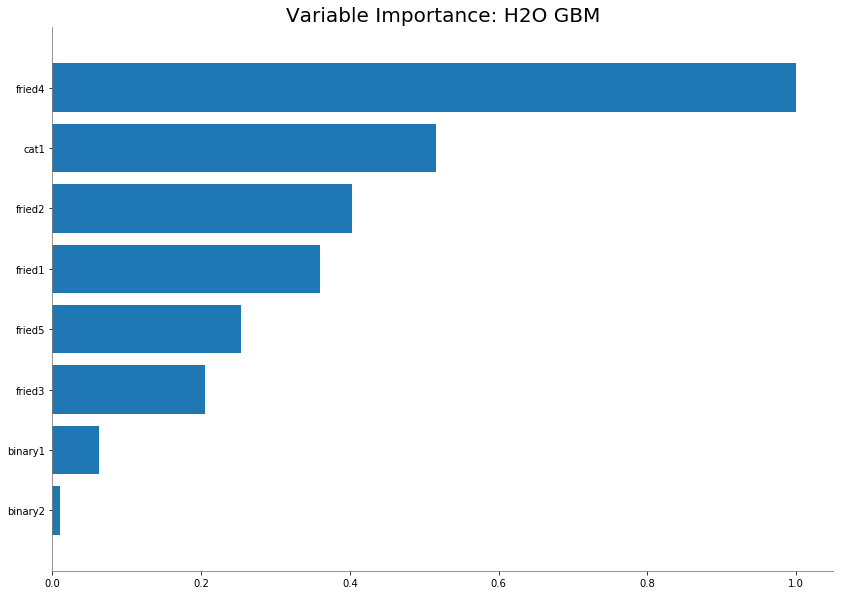

In [29]:
# MGBM var importance
mgbm_default.varimp_plot()

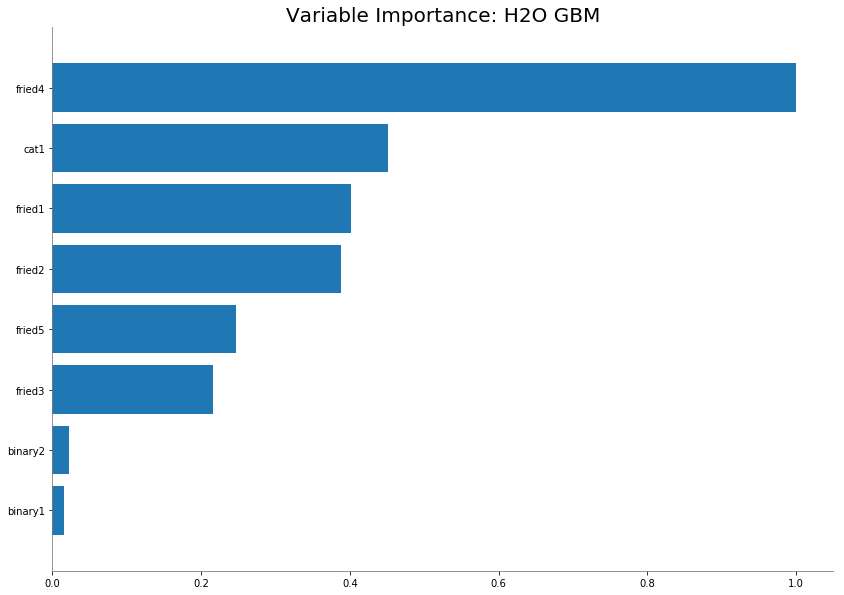

In [30]:
# GBM var importance
gbm_default.varimp_plot()

## Shapley for MGBM

In [31]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.490221,0.371436,-0.0399136,-1.01102,-0.12288,0.138734,-0.0285629,0.316549,0.0157254
0.322922,0.366827,-0.248564,1.12606,0.273615,0.135777,-0.0406532,0.454881,0.0157254
0.0731699,0.374894,-0.176071,0.117907,-0.417799,0.101677,-0.0265205,0.327378,0.0157254
-0.263766,0.330554,0.0356711,-1.10585,-0.470593,0.0790958,-0.0263165,0.299841,0.0157254
0.480919,0.284596,-0.160511,-0.878049,0.0985193,0.138903,0.0844022,-0.461652,0.0157254


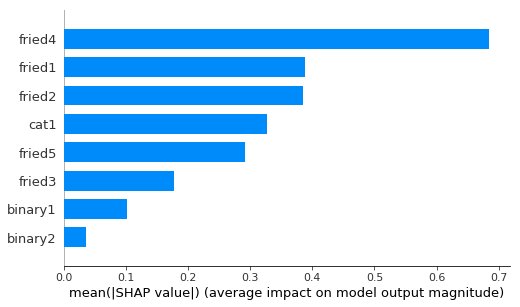

In [32]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [33]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.724602,0.550852,-0.0984897,-1.19361,-0.0960698,0.0419696,-0.061961,0.374188,-0.00467028
0.393449,0.727396,-0.300681,1.24876,0.222565,0.0756877,-0.0412661,0.391257,-0.00467028
0.130395,0.583664,-0.330525,0.137158,-0.515531,0.112987,-0.0668423,0.426591,-0.00467028
-0.383588,0.338184,-0.0101796,-1.30299,-0.490338,0.0491815,-0.08413,0.292361,-0.00467028
0.674954,0.385993,-0.286857,-1.09823,0.12537,0.070345,0.129547,-0.655237,-0.00467028


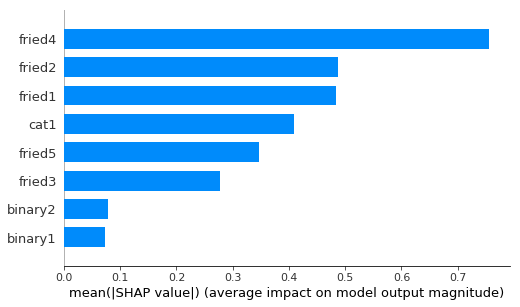

In [34]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [35]:
# Default XGBoost with monotonic constraints
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [36]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575671949109_21538


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15881399733486773
RMSE: 0.3985147391689142
LogLoss: 0.48057373765955025
Mean Per-Class Error: 0.2348163618396515
AUC: 0.8489924191721885
pr_auc: 0.8449761982811562
Gini: 0.697984838344377

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38852688159261434: 


,,0,1,Error,Rate
0,0,25435.0,14617.0,0.365,(14617.0/40052.0)
1,1,5335.0,34613.0,0.1335,(5335.0/39948.0)
2,Total,30770.0,49230.0,0.2494,(19952.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.388527,0.776268,246.0
1,max f2,0.191724,0.862965,324.0
2,max f0point5,0.617209,0.777684,153.0
3,max accuracy,0.496229,0.765175,202.0
4,max precision,0.996927,1.000000,0.0
5,max recall,0.004450,1.000000,399.0
6,max specificity,0.996927,1.000000,0.0
7,max absolute_mcc,0.496229,0.530409,202.0
8,max min_per_class_accuracy,0.503626,0.764544,199.0
9,max mean_per_class_accuracy,0.496229,0.765184,202.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.03 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.984673,1.995094,1.995094,0.996250,0.991035,0.996250,0.991035,0.019951,0.019951,99.509362,99.509362
1,,2,0.02,0.973710,1.972564,1.983829,0.985000,0.979017,0.990625,0.985026,0.019726,0.039677,97.256433,98.382898
2,,3,0.03,0.963802,1.962551,1.976736,0.980000,0.968497,0.987083,0.979516,0.019626,0.059302,96.255132,97.673642
3,,4,0.04,0.954547,1.957545,1.971939,0.977500,0.959117,0.984688,0.974416,0.019575,0.078878,95.754481,97.193852
4,,5,0.05,0.944797,1.932512,1.964053,0.965000,0.949689,0.980750,0.969471,0.019325,0.098203,93.251227,96.405327
5,,6,0.10,0.898462,1.888956,1.926504,0.943250,0.921591,0.962000,0.945531,0.094448,0.192650,88.895564,92.650446
6,,7,0.15,0.851574,1.781316,1.878108,0.889500,0.875222,0.937833,0.922095,0.089066,0.281716,78.131571,87.810821
7,,8,0.20,0.802742,1.699710,1.833509,0.848750,0.827230,0.915562,0.898378,0.084985,0.366702,69.970962,83.350856
8,,9,0.30,0.701680,1.533243,1.733420,0.765625,0.752302,0.865583,0.849686,0.153324,0.520026,53.324322,73.342011
9,,10,0.40,0.601146,1.332232,1.633123,0.665250,0.651608,0.815500,0.800167,0.133223,0.653249,33.223190,63.312306




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.16533624497406946
RMSE: 0.4066155985375739
LogLoss: 0.49812593975824593
Mean Per-Class Error: 0.24574449280819288
AUC: 0.8359533708861968
pr_auc: 0.8299772748972646
Gini: 0.6719067417723936

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37575023509562017: 


,,0,1,Error,Rate
0,0,24425.0,15627.0,0.3902,(15627.0/40052.0)
1,1,5392.0,34556.0,0.135,(5392.0/39948.0)
2,Total,29817.0,50183.0,0.2627,(21019.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.375750,0.766795,250.0
1,max f2,0.172565,0.857280,329.0
2,max f0point5,0.623269,0.765803,151.0
3,max accuracy,0.519765,0.754275,192.0
4,max precision,0.996738,1.000000,0.0
5,max recall,0.004816,1.000000,399.0
6,max specificity,0.996738,1.000000,0.0
7,max absolute_mcc,0.519765,0.508750,192.0
8,max min_per_class_accuracy,0.504054,0.753795,199.0
9,max mean_per_class_accuracy,0.519765,0.754256,192.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.14 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.985497,1.985081,1.985081,0.991250,0.991588,0.991250,0.991588,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.975171,1.950035,1.967558,0.973750,0.980299,0.982500,0.985943,0.019500,0.039351,95.003505,96.755783
2,,3,0.03,0.965491,1.957545,1.964220,0.977500,0.970440,0.980833,0.980776,0.019575,0.058927,95.754481,96.422015
3,,4,0.04,0.955668,1.919996,1.953164,0.958750,0.960558,0.975313,0.975721,0.019200,0.078127,91.999599,95.316411
4,,5,0.05,0.946946,1.914989,1.945529,0.956250,0.951304,0.971500,0.970838,0.019150,0.097276,91.498949,94.552919
5,,6,0.10,0.900902,1.845900,1.895714,0.921750,0.923777,0.946625,0.947307,0.092295,0.189571,84.589967,89.571443
6,,7,0.15,0.852401,1.768799,1.853409,0.883250,0.876754,0.925500,0.923790,0.088440,0.278011,76.879944,85.340943
7,,8,0.20,0.804555,1.665165,1.806348,0.831500,0.828562,0.902000,0.899983,0.083258,0.361270,66.516471,80.634825
8,,9,0.30,0.704798,1.502704,1.705133,0.750375,0.754930,0.851458,0.851632,0.150270,0.511540,50.270351,70.513334
9,,10,0.40,0.603671,1.309953,1.606338,0.654125,0.654341,0.802125,0.802309,0.130995,0.642535,30.995294,60.633824




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7380936,0.006255529,0.7405978,0.73570585,0.7468514,0.73743016,0.7298829
1,auc,0.8360772,0.0035750996,0.83894694,0.83406734,0.8408551,0.83300287,0.8335139
2,err,0.2619064,0.006255529,0.25940225,0.26429415,0.25314862,0.26256984,0.2701171
3,err_count,4190.8,116.720604,4166.0,4248.0,4020.0,4183.0,4337.0
4,f0point5,0.7187452,0.009057722,0.7240409,0.7143006,0.73049146,0.7180609,0.7068319
5,f1,0.7673357,0.0055390866,0.77326655,0.76365864,0.7733424,0.76459,0.7618211
6,f2,0.8230414,0.0048163645,0.82967395,0.82034427,0.8215338,0.81756693,0.826088
7,lift_top_group,1.9852865,0.020736892,1.9592743,1.9835894,1.9722692,2.0102208,2.0010786
8,logloss,0.49811688,0.0051254933,0.49393535,0.50144434,0.49127916,0.5022704,0.50165516
9,max_per_class_error,0.38836038,0.017202092,0.3947435,0.3889915,0.36514786,0.38108918,0.4118298



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 15:43:34,22.089 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-06 15:43:35,22.159 sec,1.0,0.472539,0.639023,0.760545,0.715970,1.936035,0.345350
2,,2019-12-06 15:43:35,22.201 sec,2.0,0.457589,0.609210,0.775795,0.747795,1.950119,0.318900
3,,2019-12-06 15:43:35,22.246 sec,3.0,0.448133,0.589588,0.783277,0.763214,1.976472,0.299563
4,,2019-12-06 15:43:35,22.305 sec,4.0,0.441382,0.575330,0.791179,0.787873,1.990697,0.299563
5,,2019-12-06 15:43:35,22.370 sec,5.0,0.436547,0.564639,0.795395,0.791039,1.985508,0.306100
6,,2019-12-06 15:43:35,22.442 sec,6.0,0.432928,0.556647,0.800121,0.798847,1.986284,0.300800
7,,2019-12-06 15:43:35,22.510 sec,7.0,0.429826,0.549728,0.804110,0.804145,1.995103,0.297063
8,,2019-12-06 15:43:35,22.584 sec,8.0,0.427361,0.544082,0.807327,0.807593,1.985124,0.293800
9,,2019-12-06 15:43:35,22.656 sec,9.0,0.425432,0.539504,0.809336,0.808790,1.992677,0.290812



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,22084.916016,1.000000,0.354201
1,cat1,10907.036133,0.493868,0.174929
2,fried1,9284.097656,0.420382,0.148900
3,fried2,8568.784180,0.387993,0.137428
4,fried5,5628.889160,0.254875,0.090277
5,fried3,4705.663574,0.213071,0.075470
6,binary1,603.105469,0.027308,0.009673
7,binary2,568.813721,0.025756,0.009123


In [37]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8378534259722898


In [38]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.8359533708861968


In [39]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [40]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575671949109_21911


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14643942386493092
RMSE: 0.3826740438871324
LogLoss: 0.4490402437491071
Mean Per-Class Error: 0.21313781145290145
AUC: 0.8711291825208185
pr_auc: 0.8672979752765261
Gini: 0.742258365041637

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4068851442012972: 


,,0,1,Error,Rate
0,0,28021.0,12031.0,0.3004,(12031.0/40052.0)
1,1,5638.0,34310.0,0.1411,(5638.0/39948.0)
2,Total,33659.0,46341.0,0.2209,(17669.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.406885,0.795235,233.0
1,max f2,0.200026,0.870637,316.0
2,max f0point5,0.620768,0.800916,153.0
3,max accuracy,0.503046,0.786863,196.0
4,max precision,0.995230,1.000000,0.0
5,max recall,0.010704,1.000000,397.0
6,max specificity,0.995230,1.000000,0.0
7,max absolute_mcc,0.503046,0.573724,196.0
8,max min_per_class_accuracy,0.503046,0.786623,196.0
9,max mean_per_class_accuracy,0.503046,0.786862,196.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.983838,1.995094,1.995094,0.996250,0.989286,0.996250,0.989286,0.019951,0.019951,99.509362,99.509362
1,,2,0.02,0.975145,1.975068,1.985081,0.986250,0.979379,0.991250,0.984333,0.019751,0.039702,97.506759,98.508060
2,,3,0.03,0.967448,1.975068,1.981743,0.986250,0.971208,0.989583,0.979958,0.019751,0.059452,97.506759,98.174293
3,,4,0.04,0.960042,1.977571,1.980700,0.987500,0.963700,0.989062,0.975893,0.019776,0.079228,97.757084,98.069991
4,,5,0.05,0.953060,1.957545,1.976069,0.977500,0.956560,0.986750,0.972027,0.019575,0.098803,95.754481,97.606889
5,,6,0.10,0.916258,1.913488,1.944778,0.955500,0.934914,0.971125,0.953470,0.095674,0.194478,91.348753,94.477821
6,,7,0.15,0.875135,1.824372,1.904643,0.911000,0.895842,0.951083,0.934261,0.091219,0.285696,82.437168,90.464270
7,,8,0.20,0.831016,1.758786,1.868179,0.878250,0.853470,0.932875,0.914063,0.087939,0.373636,75.878642,86.817863
8,,9,0.30,0.733133,1.604336,1.780231,0.801125,0.782766,0.888958,0.870298,0.160434,0.534069,60.433564,78.023097
9,,10,0.40,0.620492,1.392060,1.683188,0.695125,0.677364,0.840500,0.822064,0.139206,0.673275,39.205968,68.318814




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1633755608042339
RMSE: 0.404197428002992
LogLoss: 0.4940305264009453
Mean Per-Class Error: 0.24028642733406214
AUC: 0.8399647189153749
pr_auc: 0.8350944355843084
Gini: 0.6799294378307499

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38727608335162944: 


,,0,1,Error,Rate
0,0,26112.0,13940.0,0.348,(13940.0/40052.0)
1,1,6183.0,33765.0,0.1548,(6183.0/39948.0)
2,Total,32295.0,47705.0,0.2515,(20123.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.387276,0.770424,241.0
1,max f2,0.167430,0.858474,328.0
2,max f0point5,0.601872,0.769667,159.0
3,max accuracy,0.501751,0.759713,197.0
4,max precision,0.995614,1.000000,0.0
5,max recall,0.008936,1.000000,398.0
6,max specificity,0.995614,1.000000,0.0
7,max absolute_mcc,0.501751,0.519427,197.0
8,max min_per_class_accuracy,0.501751,0.758888,197.0
9,max mean_per_class_accuracy,0.501751,0.759714,197.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.91 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.983473,1.980074,1.980074,0.988750,0.989153,0.988750,0.989153,0.019801,0.019801,98.007410,98.007410
1,,2,0.02,0.975304,1.967558,1.973816,0.982500,0.979458,0.985625,0.984306,0.019676,0.039476,96.755783,97.381596
2,,3,0.03,0.967630,1.937519,1.961717,0.967500,0.971304,0.979583,0.979972,0.019375,0.058852,93.751877,96.171690
3,,4,0.04,0.960245,1.917493,1.950661,0.957500,0.963837,0.974063,0.975938,0.019175,0.078026,91.749274,95.066086
4,,5,0.05,0.952796,1.904976,1.941524,0.951250,0.956516,0.969500,0.972054,0.019050,0.097076,90.497647,94.152398
5,,6,0.10,0.916270,1.853409,1.897467,0.925500,0.934595,0.947500,0.953324,0.092670,0.189747,85.340943,89.746671
6,,7,0.15,0.875219,1.760789,1.851907,0.879250,0.896045,0.924750,0.934231,0.088039,0.277786,76.078903,85.190748
7,,8,0.20,0.830583,1.668669,1.806098,0.833250,0.853239,0.901875,0.913983,0.083433,0.361220,66.866927,80.609793
8,,9,0.30,0.731180,1.524732,1.712309,0.761375,0.781904,0.855042,0.869957,0.152473,0.513693,52.473215,71.230934
9,,10,0.40,0.618538,1.331481,1.617102,0.664875,0.674965,0.807500,0.821209,0.133148,0.646841,33.148093,61.710223




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7462801,0.009637171,0.7491283,0.74379396,0.7564861,0.75092584,0.7310663
1,auc,0.8399911,0.003676402,0.84353626,0.837517,0.843986,0.83927226,0.8356438
2,err,0.2537199,0.009637171,0.25087172,0.25620607,0.24351385,0.24907413,0.26893374
3,err_count,4060.0,170.73517,4029.0,4118.0,3867.0,3968.0,4318.0
4,f0point5,0.7282424,0.012942496,0.73280686,0.72398335,0.74247396,0.73367953,0.7082684
5,f1,0.7708792,0.0069765076,0.77827305,0.7662883,0.7771567,0.77071536,0.76196253
6,f2,0.8189983,0.007741256,0.8297543,0.81384414,0.8152384,0.8116891,0.8244656
7,lift_top_group,1.9827536,0.022822695,1.9592743,2.0086982,1.9847519,1.9599653,2.0010786
8,logloss,0.49401858,0.0051834793,0.48916557,0.4980528,0.48815575,0.49501926,0.4996995
9,max_per_class_error,0.36175063,0.03000405,0.37326258,0.35919222,0.3311334,0.33874595,0.4064191



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 15:44:02,22.389 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-06 15:44:02,22.458 sec,1.0,0.467641,0.629706,0.787061,0.721650,1.905613,0.312837
2,,2019-12-06 15:44:02,22.503 sec,2.0,0.447934,0.591142,0.806727,0.773492,1.950119,0.283963
3,,2019-12-06 15:44:02,22.558 sec,3.0,0.435142,0.565262,0.816648,0.784880,1.950588,0.285037
4,,2019-12-06 15:44:02,22.623 sec,4.0,0.425845,0.545948,0.825208,0.814955,1.979868,0.268462
5,,2019-12-06 15:44:02,22.695 sec,5.0,0.419635,0.532524,0.830048,0.824964,1.989414,0.265537
6,,2019-12-06 15:44:03,22.772 sec,6.0,0.414371,0.521026,0.835192,0.830341,1.990287,0.258100
7,,2019-12-06 15:44:03,22.849 sec,7.0,0.410484,0.512470,0.839638,0.836735,1.978062,0.252837
8,,2019-12-06 15:44:03,22.929 sec,8.0,0.407529,0.505651,0.842463,0.839928,1.987659,0.249663
9,,2019-12-06 15:44:03,23.019 sec,9.0,0.404722,0.499246,0.845379,0.842743,1.980130,0.248138



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4,24609.298828,1.000000,0.323030
1,fried1,12273.410156,0.498731,0.161105
2,cat1,11723.783203,0.476396,0.153890
3,fried2,11054.709961,0.449209,0.145108
4,fried5,7544.623535,0.306576,0.099033
5,fried3,7438.889160,0.302280,0.097645
6,binary1,811.313843,0.032968,0.010650
7,binary2,726.791870,0.029533,0.009540


In [41]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8434613754497244


In [42]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8399647189153749


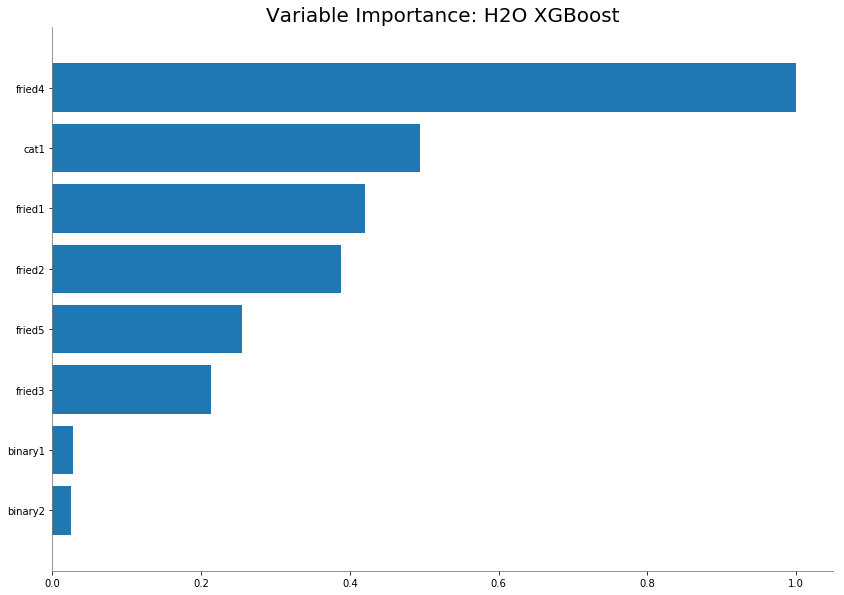

In [43]:
# MXGB var importance
mxgb_default.varimp_plot()

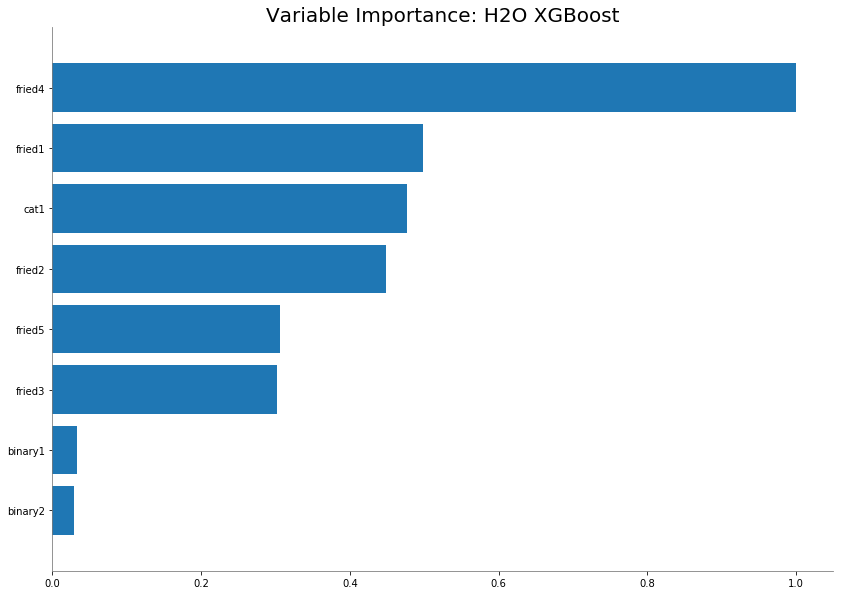

In [44]:
# XGB var importance
xgb_default.varimp_plot()

## Shapey for MXGB

In [45]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.442995,0.214441,-0.156532,-0.681815,-0.00939882,0.0702496,-0.0932205,0.185657,0
0.620059,0.788053,-0.0980363,1.38616,0.367607,0.196831,-0.0955655,0.348525,0
0.0164058,0.389496,-0.291093,0.187521,-0.336007,0.0905225,-0.0934831,0.229716,0
-0.554114,0.0181265,-0.383173,-0.973048,-0.5313,0.09343,-0.160146,0.167194,0
0.245689,0.0136229,-0.391003,-0.622293,0.131283,0.0570221,0.172265,-0.427469,0


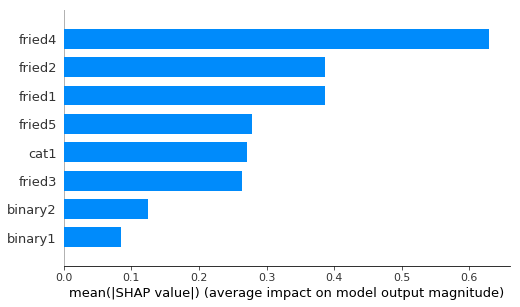

In [46]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [47]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.438743,0.0946847,-0.0976143,-0.724417,-0.0240735,0.188405,-0.104865,0.301263,0
0.661611,0.718997,0.120627,1.54829,0.273809,0.215398,-0.0544246,0.421737,0
0.0967965,0.313333,-0.335005,0.143391,-0.39538,0.150863,-0.0575384,0.327164,0
-0.409495,-0.146475,-0.035943,-0.920038,-0.514878,0.0688983,-0.0614022,0.274107,0
0.423249,0.0605989,-0.347105,-0.662977,0.0914316,0.0852577,0.190206,-0.461607,0


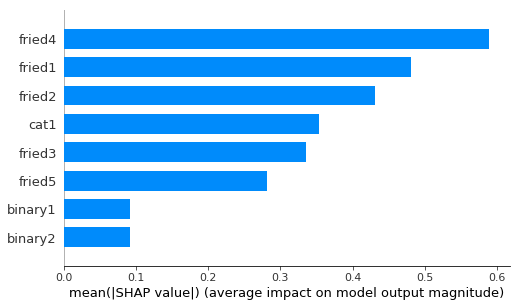

In [48]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

# MGBM Grid Search (Constrained)

In [49]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

In [50]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [51]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [52]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1                     0.8       0.09        10  0.7000000000000001   
2      0.7000000000000001       0.09        10                 0.5   
3                     1.0       0.09        10                 0.9   
4                     1.0       0.09         5                 0.5   
5                     0.9       0.08         6                 0.8   
6      0.7000000000000001       0.08         9  0.6000000000000001   
7     0.30000000000000004        0.1         6  0.7000000000000001   
8      0.7000000000000001        0.1         3  0.7000000000000001   
9                     0.4       0.08         5                 0.8   
10    0.30000000000000004       0.08         6                 0.8   
11                    0.9       0.06         6                 0.9   
12                    0.4       0.07         5                 0.5   
13                  

In [53]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.8396159089508861

In [54]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.471087,0.379033,-0.00722837,-1.00171,-0.112411,0.163969,-0.0566585,0.346343,0.013686
0.311974,0.447466,-0.238506,1.17789,0.228146,0.240036,-0.0586846,0.558017,0.013686
0.0181621,0.357954,-0.185231,0.170151,-0.423924,0.147952,-0.0397504,0.414331,0.013686
-0.381376,0.274041,0.024561,-1.04478,-0.464404,0.107334,-0.0526592,0.285863,0.013686
0.462169,0.271749,-0.166308,-0.861589,0.101199,0.181823,0.194259,-0.521857,0.013686


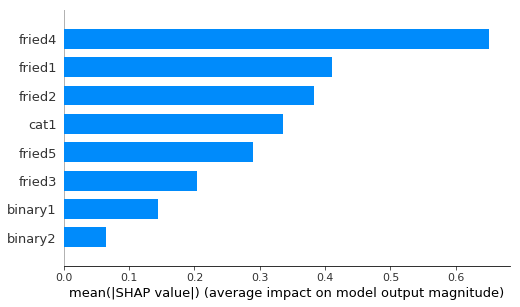

In [55]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [56]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MGBM_BEST_GRID_v2_SIMULATED_1575676115.1723905/mgbm_grid2_simulated_model_20


# GBM Grid Search (Unconstrained)

In [57]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [58]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [59]:
print(gbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1                     1.0       0.09         5                 0.5   
2                     0.9       0.08         6                 0.8   
3     0.30000000000000004       0.08         6                 0.8   
4                     0.5        0.1         8  0.7000000000000001   
5                     0.4       0.04         9                 0.5   
6      0.7000000000000001       0.08         9  0.6000000000000001   
7                     0.9       0.06         6                 0.9   
8     0.30000000000000004       0.04        10                 0.9   
9                     0.4       0.08         5                 0.8   
10                    0.1        0.1        10                 0.5   
11     0.7000000000000001       0.04         8                 1.0   
12                    0.8       0.05        10  0.6000000000000001   
13                  

In [60]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.8464303154672332

In [61]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.712444,0.484033,-0.0292182,-1.0783,-0.0689788,0.144068,-0.0628931,0.387311,-0.00447395
0.387904,0.635555,-0.217367,1.29547,0.280237,0.230333,-0.0468988,0.464236,-0.00447395
0.0394849,0.552142,-0.291235,0.196625,-0.577763,0.145431,-0.0816981,0.448272,-0.00447395
-0.405597,0.342999,0.199578,-1.13792,-0.527172,0.117731,-0.100027,0.347015,-0.00447395
0.579179,0.282835,-0.314487,-1.05021,0.101845,0.153361,0.195643,-0.683167,-0.00447395


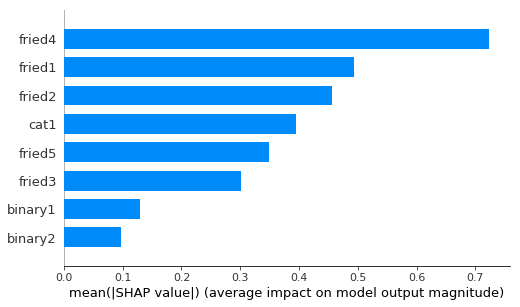

In [62]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [63]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/GBM_BEST_GRID_v2_SIMULATED_1575676401.0933318/gbm_grid2_simulated_model_12


# Repeat Previous but with XGBoost

In [64]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [65]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [66]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1     0.30000000000000004       0.08         6                 0.8   
2      0.7000000000000001        0.1         3  0.7000000000000001   
3                     0.5        0.1         8  0.7000000000000001   
4                     0.4       0.08         5                 0.8   
5      0.7000000000000001       0.09        10                 0.5   
6                     0.4       0.07         5                 0.5   
7                     0.8       0.09        10  0.7000000000000001   
8      0.7000000000000001       0.08         9  0.6000000000000001   
9                     1.0       0.09         5                 0.5   
10                    0.9       0.08         6                 0.8   
11                    1.0       0.09        10                 0.9   
12                    0.1        0.1        10                 0.5   
13                  

In [67]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.8432946051678827

In [68]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.509702,0.337086,-0.0348898,-0.631416,-0.105798,0.0791485,-0.0355995,0.197201,0
0.575709,0.59123,0.074454,1.13923,0.364395,0.320235,0.0271723,0.373019,0
0.0676989,0.269696,-0.125291,0.103517,-0.370621,0.134801,-0.00919436,0.209579,0
-0.429013,0.167335,-0.022932,-0.753162,-0.479603,0.0715984,-0.101086,0.122181,0
0.45901,0.156102,-0.242493,-0.587469,0.0203461,0.087397,0.167791,-0.358281,0


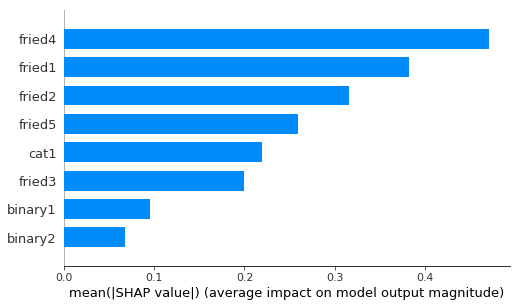

In [69]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [70]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MXGB_BEST_GRID_v2_SIMULATED_1575676946.8763347/mxgb_grid2_simulated_model_12


In [71]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [72]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [73]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     1.0       0.09         5                 0.5   
1     0.30000000000000004        0.1         6  0.7000000000000001   
2                     0.4       0.08         5                 0.8   
3     0.30000000000000004       0.08         6                 0.8   
4                     0.4       0.07         5                 0.5   
5                     0.9       0.08         6                 0.8   
6                     0.9       0.06         6                 0.9   
7                     0.1        0.1        10                 0.5   
8                     0.4       0.04         9                 0.5   
9                     0.2       0.09         6                 1.0   
10     0.7000000000000001        0.1         3  0.7000000000000001   
11     0.6000000000000001       0.04         7                 0.8   
12    0.30000000000000004       0.04        10                 0.9   
13     0.70000000000

In [74]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.8477449926890376

In [75]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



fried1,fried2,fried3,fried4,fried5,binary1,binary2,cat1,BiasTerm
0.488988,0.414116,-0.196186,-0.631582,-0.0205646,0.0829256,-0.0757101,0.228314,0
0.458245,1.1374,-0.136933,1.13673,0.403186,0.106181,-0.016364,0.3639,0
0.00936237,0.54601,-0.402503,0.112445,-0.310077,0.116455,-0.0763666,0.306909,0
-0.418595,0.218162,-0.107993,-0.901828,-0.421766,0.101075,-0.106414,0.18404,0
0.330309,0.127184,-0.359565,-0.772128,0.0952107,0.0841898,0.160139,-0.41917,0


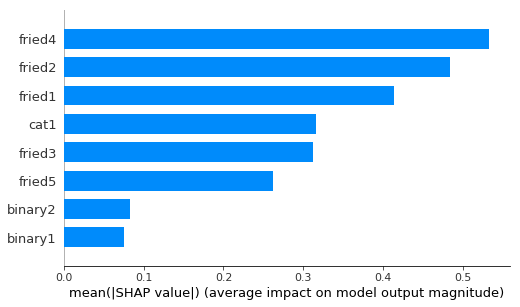

In [76]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [77]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/XGB_BEST_GRID_v2_SIMULATED_1575677912.8558497/xgb_grid2_simulated_model_24
